In [11]:
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [104]:
df = pd.read_csv('saas.csv')

In [105]:
df.shape

(790458, 5)

In [106]:
df.dtypes

Month_Invoiced        object
Customer_Id            int64
Invoice_Id             int64
Subscription_Type    float64
Amount               float64
dtype: object

In [107]:
df['Month_Invoiced'] = pd.to_datetime(df.Month_Invoiced)

In [108]:
df.isnull().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [33]:
df.head(3)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0


In [34]:
df.tail(3)

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0
790457,2017-12-31,1029399,5790457,0.0,0.0


In [35]:
df.describe()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
count,7.904580e+05,7.904580e+05,790458.000000,790458.000000
mean,1.012913e+06,5.395228e+06,0.599235,2.996174
std,7.591992e+03,2.281857e+05,0.950380,4.751901
min,1.000000e+06,5.000000e+06,0.000000,0.000000
25%,1.006405e+06,5.197614e+06,0.000000,0.000000
50%,1.012797e+06,5.395228e+06,0.000000,0.000000
75%,1.019154e+06,5.592843e+06,1.000000,5.000000
max,1.029399e+06,5.790457e+06,4.000000,20.000000


In [109]:
df.set_index('Month_Invoiced', inplace=True)
df.head(3)

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0


In [110]:
aggregation = 'sum'

In [111]:
train = df[:'2016'].Amount.resample('M').agg(aggregation)
test = df['2017':].Amount.resample('M').agg(aggregation)

In [112]:
train.head()

Month_Invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: Amount, dtype: float64

In [59]:
train.tail()

Month_Invoiced
2016-08-31    52940.0
2016-09-30    52975.0
2016-10-31    53190.0
2016-11-30    53375.0
2016-12-31    53320.0
Freq: M, Name: Amount, dtype: float64

In [60]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 48
Training Observations: 36
Testing Observations: 12


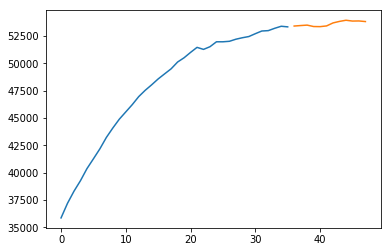

In [61]:
plt.plot(train.values)
plt.plot([None for i in train.values] + [x for x in test.values])
plt.show()

In [62]:
yhat = pd.DataFrame(dict(actual=test))

In [63]:
yhat['avg_amount'] = train.mean()
yhat.head()

,actual,avg_amount
Month_Invoiced,,
2017-01-31,53395.0,47916.666667
2017-02-28,53440.0,47916.666667
2017-03-31,53480.0,47916.666667
2017-04-30,53350.0,47916.666667
2017-05-31,53340.0,47916.666667


In [64]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

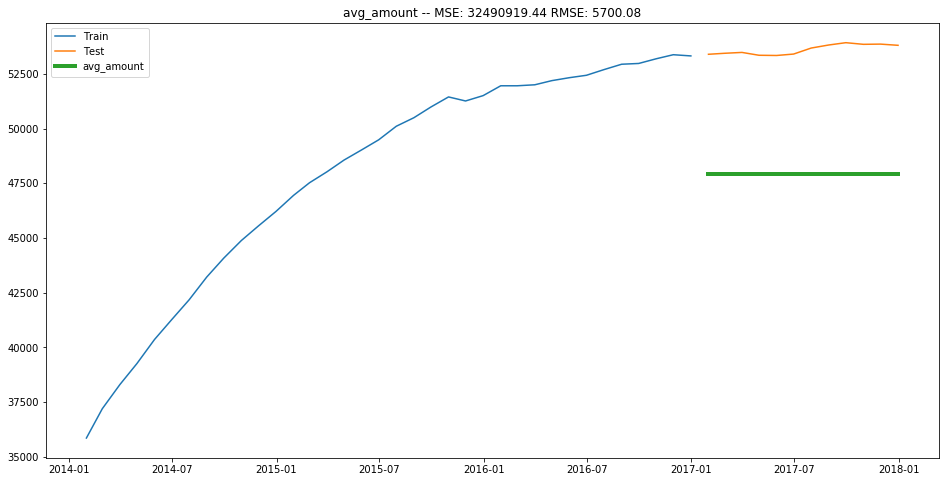

In [65]:
plot_and_eval(yhat.avg_amount)

In [113]:
periods = 3
yhat['moving_avg_forecast_3'] = train.rolling(periods).mean().iloc[-1]

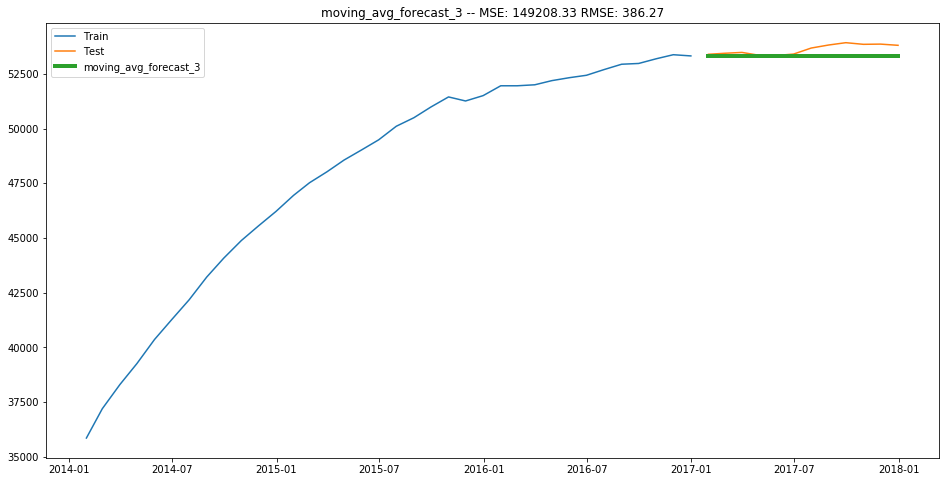

In [114]:
plot_and_eval(yhat.moving_avg_forecast_3)

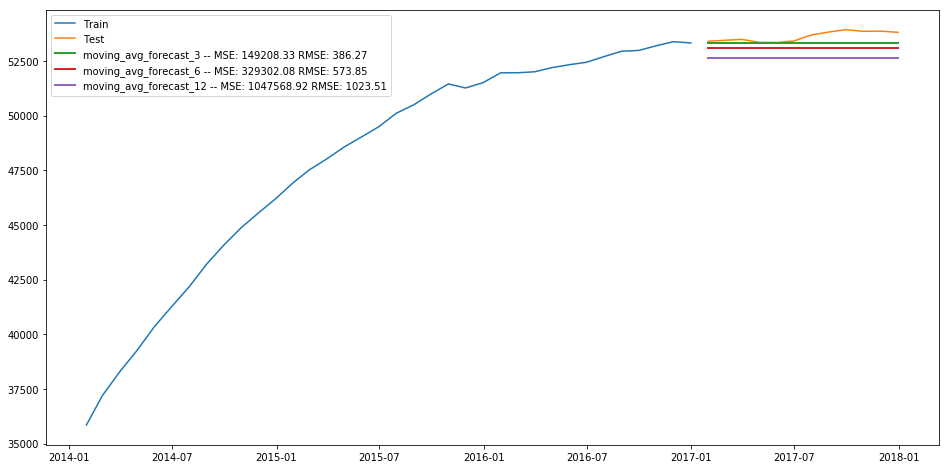

In [68]:
period_vals = [3, 6, 12]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, linewidth=2)

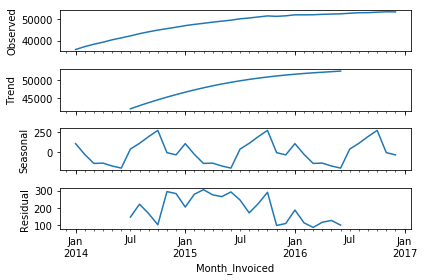

In [69]:
import statsmodels.api as sm

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

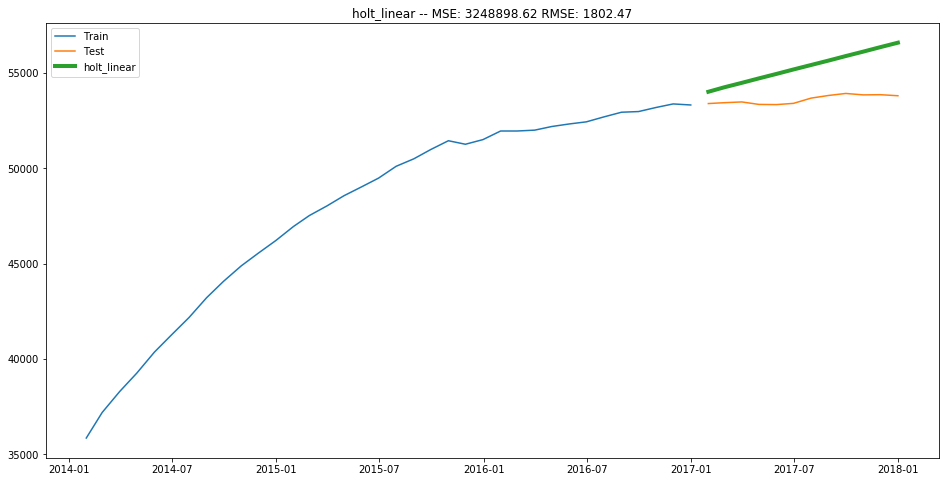

In [70]:
from statsmodels.tsa.api import Holt

holt = Holt(train).fit(smoothing_level=.3, smoothing_slope=.1)
yhat['holt_linear'] = holt.forecast(test.shape[0])

plot_and_eval(yhat.holt_linear)

In [74]:
train.head()

Month_Invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
Freq: M, Name: Amount, dtype: float64

In [101]:
using_last_year = train['2016']\
    .reset_index()\
    .drop(columns='Amount')\
    .set_index(train['2016'].index + 12)\
    .iloc[:-1]

yhat['last_year'] = using_last_year

TypeError: ufunc subtract cannot use operands with types dtype('float64') and dtype('<M8[ns]')

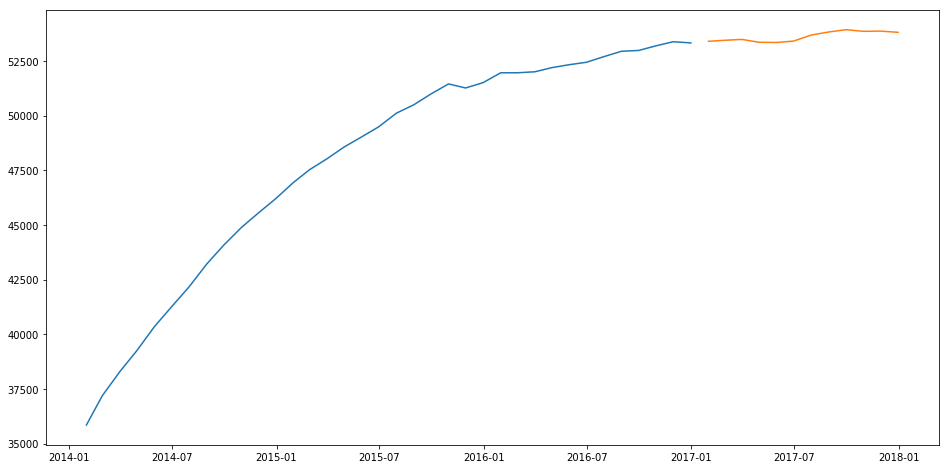

In [102]:
plot_and_eval(yhat.last_year, linewidth=1)

In [134]:
import acquire
from acquire import items_acquisition
from acquire import stores_acquisitions
from acquire import sales_acquisitions
from acquire import merge_dfs_from_csv

import summarize
from summarize import df_summary
from summarize import nulls_by_col
from summarize import nulls_by_row
from summarize import df_value_counts

from fbprophet import Prophet

In [118]:
df = merge_dfs_from_csv()

(913000, 14)


In [119]:
df['day_o_the_week'] = df['sale_date'].str.split(',').str[0]
df['date'] = df['sale_date'].str.split(', ').str[1]
df['date'] = df['date'].str.replace(' ', '-', 2)
df['time'] = df['date'].str.split(' ').str[1]
df['zone'] = df['date'].str.split(' ').str[2]
df['date'] = df['date'].str.split(' ').str[0]
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['quarter'] = df.date.dt.quarter
df['day_of_the_week'] = df.date.dt.dayofweek
df['is_weekend'] = df.day_o_the_week.str.startswith('S')

In [120]:
def improve_sales_data(df):
    df['sale_total'] = df.sale_amount * df.item_price
    return df.rename(columns={'sale_amount':'quantity'}, inplace=True)

In [121]:
improve_sales_data(df)

In [122]:
df.head(3).T

,0,1,2
item,1,1,1
quantity,13,11,14
sale_date,"Tue, 01 Jan 2013 00:00:00 GMT","Wed, 02 Jan 2013 00:00:00 GMT","Thu, 03 Jan 2013 00:00:00 GMT"
sale_id,1,2,3
store,1,1,1
item_brand,Riceland,Riceland,Riceland
item_name,Riceland American Jazmine Rice,Riceland American Jazmine Rice,Riceland American Jazmine Rice
item_price,0.84,0.84,0.84
item_upc12,35200264013,35200264013,35200264013
item_upc14,35200264013,35200264013,35200264013


In [126]:
df.store.value_counts()

10    91300
9     91300
8     91300
7     91300
6     91300
5     91300
4     91300
3     91300
2     91300
1     91300
Name: store, dtype: int64

In [167]:
d_df = df[df['store']==2]
d_df.shape

(91300, 25)

In [168]:
d_df['y'] = d_df.quantity * d_df.item_price
d_df['ds'] = pd.to_datetime(d_df.sale_date)
d_df = d_df.groupby(['ds'])['y'].sum()
d_df.head()

ds
2013-01-01     9554.44
2013-01-02     9696.05
2013-01-03    10250.73
2013-01-04    10784.40
2013-01-05    11362.45
Name: y, dtype: float64

In [169]:
d_df = d_df.to_frame()
d_df.head()

,y
ds,
2013-01-01,9554.44
2013-01-02,9696.05
2013-01-03,10250.73
2013-01-04,10784.40
2013-01-05,11362.45


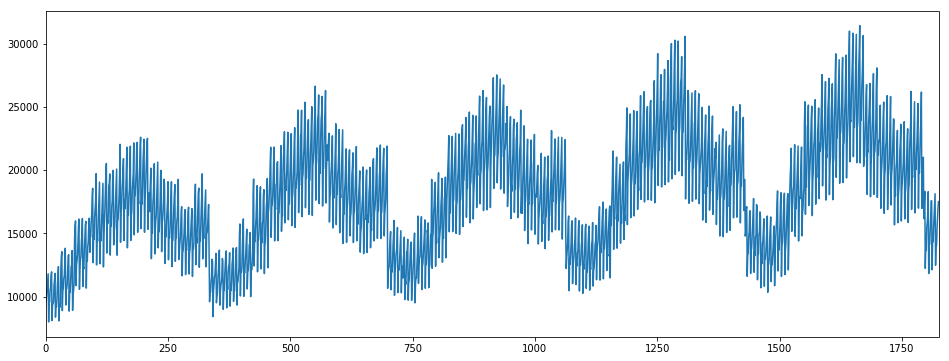

In [141]:
plt.figure(figsize=(16,6))
sns.tsplot(d_df.y)

In [170]:
d_df.reset_index(inplace=True)
d_df.head()

,ds,y
0,2013-01-01,9554.44
1,2013-01-02,9696.05
2,2013-01-03,10250.73
3,2013-01-04,10784.40
4,2013-01-05,11362.45


In [172]:
d_df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [173]:
d_df.set_index('ds', inplace=True)
d_df.head(3)

,y
ds,
2013-01-01,9554.44
2013-01-02,9696.05
2013-01-03,10250.73


In [174]:
d_df = d_df.y.resample('M').agg('sum')
d_df.head()

ds
2013-01-31    313859.06
2013-02-28    318672.05
2013-03-31    427780.05
2013-04-30    473620.81
2013-05-31    529055.80
Freq: M, Name: y, dtype: float64

In [175]:
d_df = d_df.to_frame()
d_df.head()

,y
ds,
2013-01-31,313859.06
2013-02-28,318672.05
2013-03-31,427780.05
2013-04-30,473620.81
2013-05-31,529055.80


In [176]:
d_df.reset_index(inplace=True)
d_df.head()

,ds,y
0,2013-01-31,313859.06
1,2013-02-28,318672.05
2,2013-03-31,427780.05
3,2013-04-30,473620.81
4,2013-05-31,529055.80


In [202]:
d_df['cap'] = 700000
d_df['floor'] = 200000

m = Prophet(growth='logistic', changepoint_range=0.9)
m.fit(d_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [203]:
future = m.make_future_dataframe(periods=12, freq='M')
future['cap'] = 700000
future['floor'] = 200000
print(future.head())
print(future.tail())
print(d_df.tail())

          ds     cap   floor
0 2013-01-31  700000  200000
1 2013-02-28  700000  200000
2 2013-03-31  700000  200000
3 2013-04-30  700000  200000
4 2013-05-31  700000  200000
           ds     cap   floor
67 2018-08-31  700000  200000
68 2018-09-30  700000  200000
69 2018-10-31  700000  200000
70 2018-11-30  700000  200000
71 2018-12-31  700000  200000
           ds          y     cap   floor
55 2017-08-31  708615.25  700000  200000
56 2017-09-30  645164.01  700000  200000
57 2017-10-31  615199.30  700000  200000
58 2017-11-30  640308.70  700000  200000
59 2017-12-31  478962.97  700000  200000


In [204]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
67,2018-08-31,724894.591603,706720.182752,743568.804791
68,2018-09-30,656985.808472,637258.936858,674287.934596
69,2018-10-31,635234.117804,616504.619054,655196.150034
70,2018-11-30,656630.461946,638752.585466,676059.995437
71,2018-12-31,503919.576043,485359.725767,523317.489193


In [216]:
forecast_2018 = forecast.tail(12)
forecast_2018.shape

(12, 18)

In [221]:
forecast_2018 = forecast_2018[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [239]:
store = ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2']
store = pd.DataFrame(store)
store.rename(index=str, columns={'0':'store_id'}, inplace=True)
store

,0
0,2
1,2
2,2
3,2
4,2
5,2
6,2
7,2
8,2
9,2


In [226]:
forecast_2018.reset_index(inplace=True)

In [229]:
forecast_2018.drop(columns=['index'], axis=1, inplace=True)

In [231]:
forecast_2018 = forecast_2018.join(store)

In [242]:
forecast_2018 = forecast_2018.rename(index=str, columns={'0':'store_id'})
forecast_2018

,ds,yhat,yhat_lower,yhat_upper,0
0,2018-01-31,479029.292918,459655.641960,498365.643804,2
1,2018-02-28,481641.552993,462185.120876,499821.494706,2
2,2018-03-31,603082.734543,583830.630042,621251.111947,2
3,2018-04-30,665738.625045,646058.270801,684573.573693,2
4,2018-05-31,728335.752042,709920.518726,747593.110197,2
5,2018-06-30,742698.129749,724055.426913,761542.948157,2
6,2018-07-31,803647.112868,783612.844944,822332.581815,2
7,2018-08-31,724894.591603,706720.182752,743568.804791,2
8,2018-09-30,656985.808472,637258.936858,674287.934596,2
9,2018-10-31,635234.117804,616504.619054,655196.150034,2


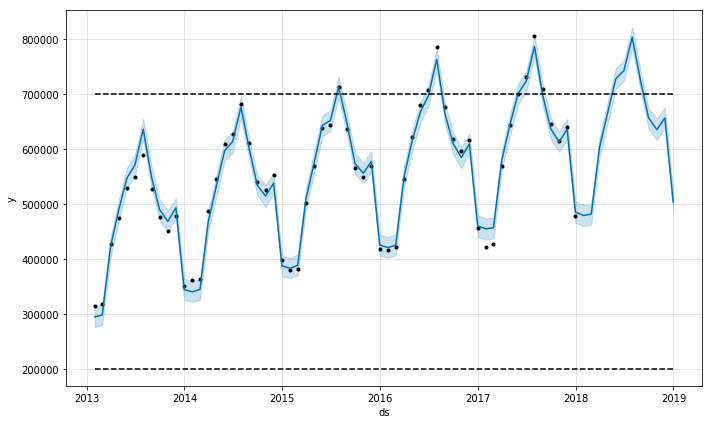

In [207]:
fig1 = m.plot(forecast)

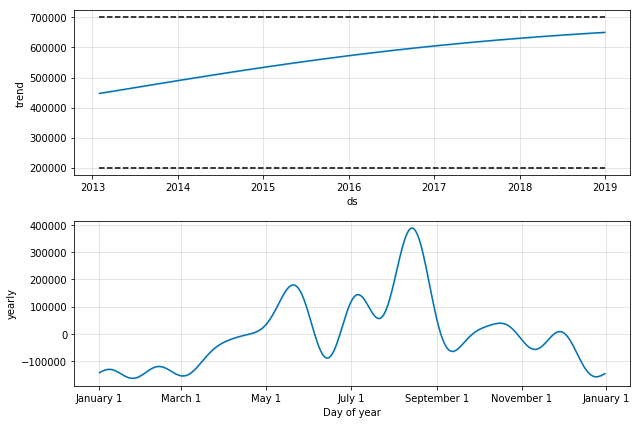

In [208]:
fig2 = m.plot_components(forecast)

In [209]:
from fbprophet.diagnostics import cross_validation, performance_metrics
# cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
df_cv = cross_validation(m, horizon='90 days')


df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 32 forecasts with cutoffs between 2013-12-07 00:00:00 and 2017-10-02 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 8.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 9.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 11.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 12.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 14.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 15.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 17.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 19.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.0.
INFO:fbprophet:n_changepoints greater than n

,horizon,mse,rmse,mae,mape,coverage
3,10 days,5.795640e+09,76129.098164,57234.366550,0.112951,0.222222
15,11 days,4.648979e+09,68183.424488,52750.186167,0.104627,0.222222
83,11 days,4.580522e+09,67679.551661,50000.919862,0.099795,0.333333
89,13 days,5.076247e+09,71247.783935,55314.719339,0.104878,0.444444
21,13 days,5.742720e+09,75780.733221,62776.289212,0.119602,0.333333


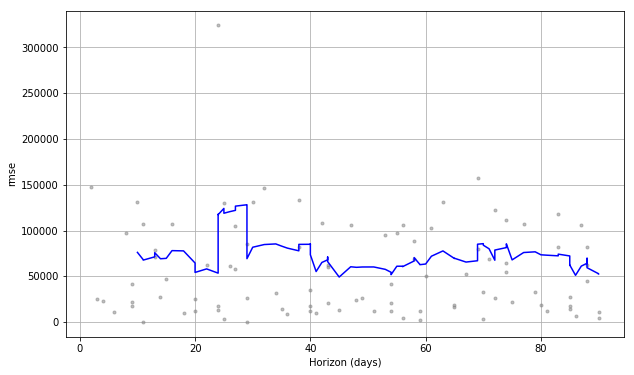

In [210]:
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

# plot_forecast_component(m, forecast, 'yhat')

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')